In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
from scipy import stats
import matplotlib.pyplot as plt
import scipy.io
import pickle

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys
from IPython.display import clear_output
np.set_printoptions(threshold=sys.maxsize)

In [13]:
Dict = {'z9': [10, 11, 12, 13, 14, 16, 19, 22, 24], 'e218': [20, 21, 22, 23, 28, 31, 32, 36, 37, 39, 40, 42, 43, 45, 48, 49, 51, 52, 53, 54, 56, 57], 'e186': [2, 3, 4, 5, 6, 35, 10, 14, 17, 21, 25, 26, 30], 'e216': [7, 8, 9, 10, 32, 33, 38, 39, 40, 42, 43, 44, 45, 46, 47, 51, 52, 55, 56, 58, 59, 61, 63], 'e190': [33, 34, 35, 41, 42, 27, 28, 29], 'e201': [66, 69, 72, 50, 51, 52, 53, 54, 57, 60, 63], 'z8': [33, 12, 13, 14, 16, 17, 21, 24, 26, 28, 30]}

In [14]:
# covert time series data from numpy to tensor
class CreateTimeSeriesData(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [16]:
# smooth the signals from binary to lick rate
def SmoothSig(TempDopa, window_size = 10):
    ts = pd.DataFrame(TempDopa.copy())
#     tss = np.array(ts.rolling(window=20, win_type="gaussian", center=True).mean(std=8))
    tss = np.array(ts.rolling(window=window_size, center=True).mean())
    tss[:window_size//2+1] = TempDopa[:window_size//2+1]
    tss[-window_size//2:] = TempDopa[-window_size//2:]
    return tss

In [ ]:
# enter the mouse id and day to get a list of Fc3 signals, dFF signals, lick rate, reward postions.
# interneuron trigger means the filter of skewness. False means skewness > 2
def GetData(mice, day, interneuron = False):
    if day < 10:
        day = '0' + str(day)
    try:
        mat = scipy.io.loadmat('Y:\\analysis\\fmats\\{}\\{}_day0{}_plane0_Fall.mat'.format(mice, mice, day))
    except:
        mat = scipy.io.loadmat('Y:\\analysis\\fmats\\{}\\days\\{}_day0{}_plane0_Fall.mat'.format(mice, mice, day))
    # print(mat.keys())
    # print(mat.keys())
    y = mat['ybinned'][0]
    licks = np.transpose(mat['licks'])
    licks = SmoothSig(licks, 15)
    licks = licks[:,0].copy()
    # the index of trials in each epoch
    Trialnum = mat['trialnum'][0]
    # The reward position in the track
    RewardPos = mat['changeRewLoc'][0]
    EpochPos = np.where(RewardPos > 0)[0]
    reward_loc = RewardPos[EpochPos]
    R = mat['rewards'][0]
    Sigs = np.transpose(mat['Fc3'])
    Sigs_dFF = np.transpose(mat['dFF'])
    skew = scipy.stats.skew(Sigs_dFF, nan_policy='omit', axis=1)
    iscell = mat['iscell']
    # print(skew[(mat['bordercells'][0] < 1) & (mat['iscell'][:,0] > 0)])
    try:
        if not interneuron:
            idx = np.where( (mat['bordercells'][0] < 1) & (mat['iscell'][:,0] > 0) & (skew > 2) )[0]
        else:
            idx = np.where( (mat['bordercells'][0] < 1) & (mat['iscell'][:,0] > 0) )[0]
        # & (skew < 2)
        # idx = np.where( (mat['iscell'][:,0] > 0) )[0]
    except:
        print('No bordercells.')
        idx = np.where( (mat['iscell'][:,0] > 0) & (skew > 2) )[0]
    og_idx = idx.copy()
    NeuronActivity = Sigs[idx,:]
    NeuronActivity_dFF = Sigs_dFF[idx,:]
    idx_new = np.where(abs(NeuronActivity.max(axis = 1)) < 20)[0]

    EpochPos = np.where(mat['changeRewLoc'][0]>0)[0]
    EpochSig = []
    EpochSig_dFF = []
    EpochY = []
    EpochLicks = []
    EpochLicksClass = []
    EpochTrialnum = []
    EpochR = []
    for i in range(len(EpochPos)-1):
        EpochSig.append(NeuronActivity[idx_new,EpochPos[i]:EpochPos[i+1]])
        EpochSig_dFF.append(NeuronActivity_dFF[idx_new,EpochPos[i]:EpochPos[i+1]])
        EpochY.append(y[EpochPos[i]:EpochPos[i+1]])
        EpochLicks.append(licks[EpochPos[i]:EpochPos[i+1]])
        EpochTrialnum.append(Trialnum[EpochPos[i]:EpochPos[i+1]])
        EpochR.append(R[EpochPos[i]:EpochPos[i+1]])
    EpochSig.append(NeuronActivity[idx_new,EpochPos[-1]:])
    EpochSig_dFF.append(NeuronActivity_dFF[idx_new,EpochPos[-1]:])
    EpochY.append(y[EpochPos[-1]:])
    EpochLicks.append(licks[EpochPos[-1]:])
    EpochTrialnum.append(Trialnum[EpochPos[-1]:])
    EpochR.append(R[EpochPos[-1]:])

    EpochTrialSigs = []
    EpochTrialSigs_dFF = []
    EpochTrialY = []
    EpochTrialLicks = []
    EpochTrialLicksClass = []
    EpochTrialR = []
    
    for epochs, epochs_dff, epochy, epocht, epochr, epochl in zip(EpochSig, EpochSig_dFF, EpochY, EpochTrialnum, EpochR, EpochLicks):
        temp_sig = []
        temp_sig_dFF = []
        temp_y = []
        temp_r = []
        temp_l = []
        for i in range(epocht[:-10].min(),epocht[10:].max()+1):
            if i >= 0:
                idx = np.where(epocht == i)[0]
                temp_sig.append(epochs[:, idx[0]:idx[-1]+1])
                temp_sig_dFF.append(epochs_dff[:, idx[0]:idx[-1]+1])
                temp_y.append(epochy[idx[0]:idx[-1]+1])
                temp_l.append(epochl[idx[0]:idx[-1]+1])
                if i < 3:
                    temp_r.append(-1)
                elif 1 in epochr[idx[0]:idx[-1]+1]:
                    temp_r.append(1)
                else:
                    temp_r.append(0)
            
        EpochTrialSigs.append(temp_sig)
        EpochTrialSigs_dFF.append(temp_sig_dFF)
        EpochTrialY.append(temp_y)
        EpochTrialLicks.append(temp_l)
        EpochTrialR.append(temp_r)

    return EpochTrialSigs, EpochTrialSigs_dFF, EpochTrialY, EpochTrialLicks, EpochTrialR, reward_loc, og_idx

# Change mouse id, day, and epoch to select which data you want to use
mouse = 'e201'
day = 51
ep = 0
Fc3, X, Y, L, TP, rl, og_idx = GetData(mouse, day, interneuron = False)
print(Fc3[0][0].shape)

In [8]:
plt.plot(L[0][1])

NameError: name 'L' is not defined

In [10]:
# Define the neuron type from the feature table created by Zahra.
# Return RR index, PP index, others in terms of spatially tuned neurons, original index gives all spatially tuned indices from
# all neurons. total_num is the total number of neurons in the feature table of this animal and this day.
# the total number should match the neuron number after skewness filter in that day, i.e., Fc3[0][0].shape[0]
def FindNeuronType(cell_features, m, d, e1, e2):
    rr_com1 = cell_features['reward_relative_circular_com']\
    [(cell_features['animal'] == m) & (cell_features['recording_day'] == d) \
     & (cell_features['epoch'] == e1) & (cell_features['spatially_tuned'] == 1)].to_numpy()
#         rr_com1 = rr_com1[abs(temp) > np.pi/8]

    rr_com2 = cell_features['reward_relative_circular_com']\
    [(cell_features['animal'] == m) & (cell_features['recording_day'] == d) \
     & (cell_features['epoch'] == e2) & (cell_features['spatially_tuned'] == 1)].to_numpy()
#         rr_com2 = rr_com2[abs(temp) > np.pi/8]

    ac_com1 = cell_features['allocentric_com']\
    [(cell_features['animal'] == m) & (cell_features['recording_day'] == d) \
     & (cell_features['epoch'] == e1) & (cell_features['spatially_tuned'] == 1)].to_numpy()
    temp = rr_com1.copy()
#         ac_com1 = ac_com1[abs(temp) > np.pi/8]

    ac_com2 = cell_features['allocentric_com']\
    [(cell_features['animal'] == m) & (cell_features['recording_day'] == d) \
     & (cell_features['epoch'] == e2) & (cell_features['spatially_tuned'] == 1)].to_numpy()
    
#     RR_List = np.where(abs(rr_com1 - rr_com2)/2/np.pi < 0.05)[0]
#     PP_List = np.where(abs(ac_com1 - ac_com2)/2/135 < 0.05)[0]
    RR_List = np.where(abs(rr_com1 - rr_com2)/2/np.pi < 20/270)[0]
    PP_List = np.where(abs(ac_com1 - ac_com2)/2/135 < 20/270)[0]
    Null_List = np.array([i for i in range(len(rr_com1)) if (i not in RR_List) and (i not in PP_List)])

    temp = np.where((cell_features['animal'] == m) & (cell_features['recording_day'] == d) & (cell_features['epoch'] == e1))[0]
    # print(temp.shape)
    Ori_idx = np.where(cell_features['spatially_tuned'][temp] == 1)[0]
    
    return RR_List, PP_List, Null_List, Ori_idx, temp.shape[0]

# change path to read your feature table
# epoch index in feature table is from 1 to n, epoch index in python is from 0 to n-1.
cell_features = pd.read_csv('D:\\Pyra_Cell_Data\\cell_features_pyr_goal.csv')
if ep == len(Fc3)-1:
    RR_List, PP_List, Null_List, Ori_idx, total_num = FindNeuronType (cell_features, mouse, day, ep, ep+1)
else:
    RR_List, PP_List, Null_List, Ori_idx, total_num = FindNeuronType (cell_features, mouse, day, ep+1, ep+2)
if total_num == Fc3[0][0].shape[0]:
    print('Same neruron number ')
else:
    print('Neuron number error, select another day.')

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Pyra_Cell_Data\\cell_features_pyr_goal.csv'

In [208]:
# Create the data for training, validating and testing. 
# input are dFF signals, Y position, licks, trial type, and epoch id for training.
# only use the pre-reward signals for training, validation, and testing. training and validation use successful trials, test uses failure trials.
# outputs are tensors of training/validation/testing data, labels.
def CreateData(Fc3, Y, L, Type, rl, epoch_num, shuffle = False):
    success_trial_id = [i for i in range(len(Type[epoch_num])) if Type[epoch_num][i] == 1]
    failure_trial_id = [i for i in range(len(Type[epoch_num])) if Type[epoch_num][i] == 0]
    print(success_trial_id)
    print(failure_trial_id)
    # EpochX = Fc3[0]
    EpochX = Fc3[epoch_num]
    # EpochX = loaded_data2[epoch_num]
    EpochY = Y[epoch_num]
    EpochL = L[epoch_num]
    # print(len(EpochX))
    
    TrainingTrial = []
    TrainingTrial = []
    ValidateTrial = []
    for i in range(0,len(success_trial_id)-1):
      if (i+2) % 3 == 0:
        ValidateTrial.append(success_trial_id[i])
      else:
        TrainingTrial.append(success_trial_id[i])
    # TestingTrial = TrainingTrial.copy()
    TestingTrial = failure_trial_id.copy()
    if len(failure_trial_id) == 0 or len(success_trial_id) == 0:
        return [], [], [], [], [], []
    # if max(failure_trial_id) < min(success_trial_id):
    #     return [], [], [], [], [], []
    # else:
    #     TestingTrial = [i for i in failure_trial_id if i > min(success_trial_id)]
    print(TestingTrial)
    
    y = EpochY[TrainingTrial[0]]
    num_per_bin, bins = np.histogram(y, np.arange(0,180,2))
    tmp_idx = np.where(num_per_bin > 10)[0]
    tmp_tr = set(np.arange(0,y.shape[0]))
    for bin_idx in tmp_idx:
      tmp_tr = tmp_tr & set(np.where( (EpochY[TrainingTrial[0]] < bins[bin_idx]) | (EpochY[TrainingTrial[0]] > bins[bin_idx+1]) )[0])
    tmp_tr = tmp_tr & set(np.where( (EpochY[TrainingTrial[0]] < rl[epoch_num]) )[0])
    tmp_tr = np.array(list(tmp_tr))
    tmp_tr = np.sort(tmp_tr)
    TrainingData = EpochX[TrainingTrial[0]][:, tmp_tr]
    TrainingLabel = EpochL[TrainingTrial[0]][tmp_tr].reshape(-1,1)

    y = EpochY[TestingTrial[0]]
    num_per_bin, bins = np.histogram(y, np.arange(0,180,2))
    tmp_idx = np.where(num_per_bin > 10)[0]
    tmp_tr = set(np.arange(0,y.shape[0]))
    for bin_idx in tmp_idx:
      tmp_tr = tmp_tr & set(np.where( (EpochY[TestingTrial[0]] < bins[bin_idx]) | (EpochY[TestingTrial[0]] > bins[bin_idx+1]) )[0])
    tmp_tr = tmp_tr & set(np.where( (EpochY[TestingTrial[0]] < rl[epoch_num]) )[0])
    tmp_tr = np.array(list(tmp_tr))
    tmp_tr = np.sort(tmp_tr)
    TestingData = EpochX[TestingTrial[0]][:, tmp_tr]
    TestingLabel = EpochL[TestingTrial[0]][tmp_tr].reshape(-1,1)
    # y = EpochY[TrainingTrial[0]]
    # tmp_tr = np.where(y < 3)[0]
    # TestingData = EpochX[TrainingTrial[0]][:, tmp_tr]
    # TestingLabel = EpochY[TrainingTrial[0]][tmp_tr].reshape(-1,1)
    
    y = EpochY[ValidateTrial[0]]
    num_per_bin, bins = np.histogram(y, np.arange(0,180,2))
    tmp_idx = np.where(num_per_bin > 10)[0]
    tmp_tr = set(np.arange(0,y.shape[0]))
    for bin_idx in tmp_idx:
      tmp_tr = tmp_tr & set(np.where( (EpochY[ValidateTrial[0]] < bins[bin_idx]) | (EpochY[ValidateTrial[0]] > bins[bin_idx+1]) )[0])
    tmp_tr = tmp_tr & set(np.where( (EpochY[ValidateTrial[0]] < rl[epoch_num]) )[0])
    tmp_tr = np.array(list(tmp_tr))
    tmp_tr = np.sort(tmp_tr)
    ValidateData = EpochX[ValidateTrial[0]][:, tmp_tr]
    ValidateLabel = EpochL[ValidateTrial[0]][tmp_tr].reshape(-1,1)
    
    for i in TrainingTrial[1:]:
      y = EpochY[i]
      num_per_bin, bins = np.histogram(y, np.arange(0,180,2))
      tmp_idx = np.where(num_per_bin > 10)[0]
      tmp_tr = set(np.arange(0,y.shape[0]))
      for bin_idx in tmp_idx:
        tmp_tr = tmp_tr & set(np.where( (EpochY[i] < bins[bin_idx]) | (EpochY[i] > bins[bin_idx+1]) )[0])
      tmp_tr = tmp_tr & set(np.where( (EpochY[i] < rl[epoch_num]) )[0])
      tmp_tr = np.array(list(tmp_tr))
      tmp_tr = np.sort(tmp_tr)
      # print(EpochX[i].shape, EpochY[i].shape)
      TrainingData = np.concatenate((TrainingData, EpochX[i][:, tmp_tr]), axis=1)
      TrainingLabel = np.concatenate((TrainingLabel, EpochL[i][tmp_tr].reshape(-1,1)), axis=0)
    
    for i in ValidateTrial[1:]:
      y = EpochY[i]
      num_per_bin, bins = np.histogram(y, np.arange(0,180,2))
      tmp_idx = np.where(num_per_bin > 10)[0]
      tmp_tr = set(np.arange(0,y.shape[0]))
      for bin_idx in tmp_idx:
        tmp_tr = tmp_tr & set(np.where( (EpochY[i] < bins[bin_idx]) | (EpochY[i] > bins[bin_idx+1]) )[0])
      tmp_tr = tmp_tr & set(np.where( (EpochY[i] < rl[epoch_num]) )[0])
      tmp_tr = np.array(list(tmp_tr))
      tmp_tr = np.sort(tmp_tr)
      ValidateData = np.concatenate((ValidateData, EpochX[i][:, tmp_tr]), axis=1)
      ValidateLabel = np.concatenate((ValidateLabel, EpochL[i][tmp_tr].reshape(-1,1)), axis=0)
    
    for i in TestingTrial[1:]:
    # for i in TrainingTrial[1:]:
      y = EpochY[i]
      # tmp_tr = np.where(y < 3)[0]
      num_per_bin, bins = np.histogram(y, np.arange(0,180,2))
      tmp_idx = np.where(num_per_bin > 10)[0]
      tmp_tr = set(np.arange(0,y.shape[0]))
      for bin_idx in tmp_idx:
        tmp_tr = tmp_tr & set(np.where( (EpochY[i] < bins[bin_idx]) | (EpochY[i] > bins[bin_idx+1]) )[0])
      tmp_tr = tmp_tr & set(np.where( (EpochY[i] < rl[epoch_num]) )[0])
      tmp_tr = np.array(list(tmp_tr))
      tmp_tr = np.sort(tmp_tr)
      TestingData = np.concatenate((TestingData, EpochX[i][:, tmp_tr]), axis=1)
      TestingLabel = np.concatenate((TestingLabel, EpochL[i][tmp_tr].reshape(-1,1)), axis=0)
    
    th = 0.01
    TrainingData = torch.tensor(TrainingData).t().float()
    TrainingLabel = torch.tensor(TrainingLabel).float()
    TestingData = torch.tensor(TestingData).t().float()
    TestingLabel = torch.tensor(TestingLabel).float()
    ValidateData = torch.tensor(ValidateData).t().float()
    ValidateLabel = torch.tensor(ValidateLabel).float()
    # TrainingData, TrainingLabel = RemoveNan(TrainingData, TrainingLabel)
    # TestingData, TestingLabel = RemoveNan(TestingData, TestingLabel)
    # ValidateData, ValidateLabel = RemoveNan(ValidateData, ValidateLabel)
    indices = torch.randperm(TrainingLabel.size(0))
    if shuffle:
        TrainingLabel = TrainingLabel[indices]
    TrainingData[TrainingData < th] = 0
    TestingData[TestingData < th] = 0
    ValidateData[ValidateData < th] = 0
    print(TrainingData.shape, TrainingLabel.shape)
    print(TestingData.shape, TestingLabel.shape)
    print(ValidateData.shape, ValidateLabel.shape)

    return TrainingData, TrainingLabel, TestingData, TestingLabel, ValidateData, ValidateLabel

Fc3, X, Y, L, TP, rl, _ = GetData(mouse, day, interneuron = False)

print(Fc3[0][0].shape)
# Although function uses variable Fc3, real input is dFF signals, X. Fc3 has a much worse performance.
TrD, TrL, TsD, TsL, VlD, VlL = CreateData(X, Y, L, TP, rl, epoch_num = ep)

C:\Users\bjian\AppData\Local\Temp\ipykernel_45888\698849444.py:25: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  skew = scipy.stats.skew(Sigs_dFF, nan_policy='omit', axis=1)


(455, 535)
[2, 3, 5, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[1, 4, 6, 8, 10]
[1, 4, 6, 8, 10]
torch.Size([2958, 455]) torch.Size([2958, 1])
torch.Size([1029, 455]) torch.Size([1029, 1])
torch.Size([1422, 455]) torch.Size([1422, 1])


In [209]:
# Convert tensor to data loader
def Data2Dataloader(TrainingData, TrainingLabel, TestingData, TestingLabel, ValidateData, ValidateLabel, batch_size = 64):
    Train_dataset = CreateTimeSeriesData(TrainingData, TrainingLabel)
    Train_loader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
    
    Test_dataset = CreateTimeSeriesData(TestingData, TestingLabel)
    Test_loader = DataLoader(dataset=Test_dataset, batch_size=batch_size, shuffle=False)
    
    Validate_dataset = CreateTimeSeriesData(ValidateData, ValidateLabel)
    Validate_loader = DataLoader(dataset=Validate_dataset, batch_size=batch_size, shuffle=False, drop_last = False)
    return Train_loader, Test_loader, Validate_loader

Train_loader, Test_loader, Validate_loader = Data2Dataloader(TrD, TrL, TsD, TsL, VlD, VlL)

In [129]:
TrD.shape

torch.Size([2958, 455])

(1232,)
0.7611111111111111


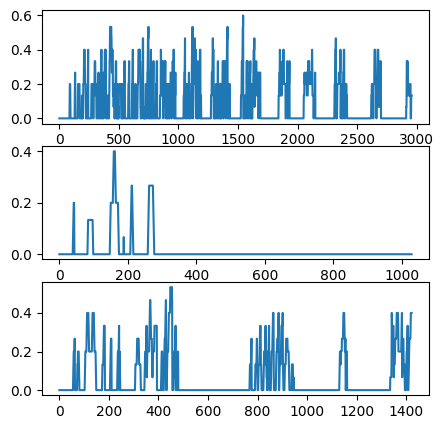

In [130]:
plt.figure(figsize = (5,5))
plt.subplot(3,1,1)
plt.plot(TrL)
print(np.where(TrL > 0)[0].shape)
# plt.axhline(y=rl[ep]/180, color='r', linestyle='--')
plt.subplot(3,1,2)
plt.plot(TsL)
# plt.axhline(y=rl[ep]/180, color='r', linestyle='--')
plt.subplot(3,1,3)
plt.plot(VlL)
# plt.axhline(y=rl[ep]/180, color='r', linestyle='--')
print(rl[ep]/180)

In [182]:
# Training process
def TrainModel(model, optimizer, device, Train_loader, Validate_loader, mse_loss, kl_loss, kl_weight, num_epochs = 1000):
    l = []
    val_l = []
    
    for epoch in range(num_epochs):
        train_loss = 0.0
        for inputs, targets in Train_loader:
            # Forward pass
            inputs, targets = inputs.to(device), targets.to(device)
            # inputs, targets = inputs.to(device), targets.squeeze(-1).to(torch.int64).to(device)
            outputs = model(inputs)
            # loss = ce_loss(outputs, targets)
            # mse = mae_loss(outputs, targets)
            loss = mse_loss(outputs, targets)
            # kl = kl_loss(model)
            # loss = ce + kl_weight*kl
    
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    
        l.append(train_loss/len(Train_loader))
        if epoch % 50 == 0:
            print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss/len(Train_loader)))
            test_loss = 0
            for inputs, targets in Validate_loader:
              # Forward pass
              inputs, targets = inputs.to(device), targets.to(device)
              # inputs, targets = inputs.to(device), targets.squeeze(-1).to(torch.int64).to(device)
              outputs = model(inputs)
              loss = mse_loss(outputs, targets)
              # loss = ce_loss(outputs, targets)
              test_loss += loss.item()
            print('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, num_epochs, test_loss/len(Test_loader)))
    return model

# training example
input_size = TrD.shape[-1]
output_size = 1
# mse loss
mse_loss = nn.MSELoss()
# linear model
model = nn.Sequential(nn.Linear(input_size, output_size), nn.ReLU())
    
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# TrD, TrL, TsD, TsL, VlD, VlL
model = TrainModel(model, optimizer, device, Train_loader, Validate_loader, mse_loss, kl_loss, kl_weight, num_epochs = 1000)

Epoch [1/1000], Train Loss: 0.0244
Epoch [1/1000], Test Loss: 0.0298
Epoch [51/1000], Train Loss: 0.0207
Epoch [51/1000], Test Loss: 0.0422
Epoch [101/1000], Train Loss: 0.0186
Epoch [101/1000], Test Loss: 0.0398
Epoch [151/1000], Train Loss: 0.0171
Epoch [151/1000], Test Loss: 0.0382
Epoch [201/1000], Train Loss: 0.0157
Epoch [201/1000], Test Loss: 0.0364
Epoch [251/1000], Train Loss: 0.0143
Epoch [251/1000], Test Loss: 0.0343
Epoch [301/1000], Train Loss: 0.0132
Epoch [301/1000], Test Loss: 0.0328
Epoch [351/1000], Train Loss: 0.0118
Epoch [351/1000], Test Loss: 0.0303
Epoch [401/1000], Train Loss: 0.0107
Epoch [401/1000], Test Loss: 0.0280
Epoch [451/1000], Train Loss: 0.0100
Epoch [451/1000], Test Loss: 0.0260
Epoch [501/1000], Train Loss: 0.0094
Epoch [501/1000], Test Loss: 0.0246
Epoch [551/1000], Train Loss: 0.0088
Epoch [551/1000], Test Loss: 0.0232
Epoch [601/1000], Train Loss: 0.0083
Epoch [601/1000], Test Loss: 0.0222
Epoch [651/1000], Train Loss: 0.0079
Epoch [651/1000], Te

0.013887465725217582


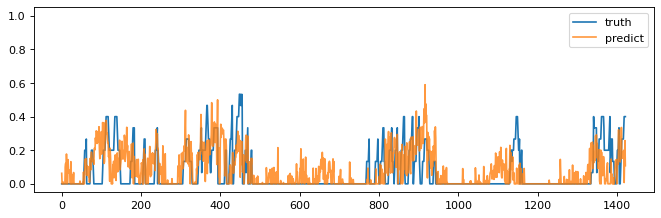

In [184]:
# check validation sets.
pred_y = np.zeros([1,1])
truth = np.zeros([1,1])
l = 0
rew_loc = rl[ep]/180
# temp_idx = torch.arange(inputs.cpu().detach().size(1))
for x,t in Validate_loader: # Test_loader for testing
# for x,t in Train_loader:
  t = t.to(device)
  # x = x[:,temp_idx].to(device)
  x = x.to(device)
  y = model(x)
  # y =torch.argmax(y, dim = 1).unsqueeze(-1)
  pred_y = np.concatenate((pred_y,y.cpu().detach().numpy()), axis = 0)
  truth = np.concatenate((truth,t.cpu().detach().numpy()), axis = 0)
  loss = mse_loss(t, y)
  l += loss.item()
print(l/len(Validate_loader))
plt.figure(figsize=(10, 3), dpi=80)
plt.plot(truth[1:], label = 'truth')
plt.plot(pred_y[1:], alpha = 0.8, label = 'predict')
plt.ylim(-0.05,1.05)
plt.legend()
plt.show()

([<matplotlib.axis.YTick at 0x18e65f3e180>], [Text(0, 0, '0')])

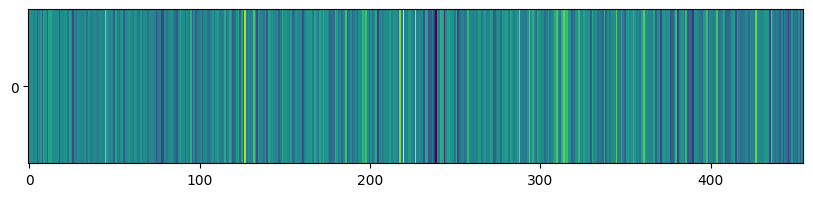

In [187]:
# get weights of linear model
weights = model.state_dict()['0.weight'].detach().cpu().numpy()
plt.figure(figsize = (10, 2))
plt.imshow(weights, aspect = 'auto', interpolation = 'None')
plt.yticks([0])

In [189]:
# find top 20 percent of neurons that contribute to the prediction based on the weight.
def top_percent_indices(vector, percent):
    vector = np.asarray(vector)
    n = len(vector)
    k = int(n * percent)
    if k == 0:
        return np.array([])
    indices = np.argpartition(vector, -k)[-k:]
    indices = indices[np.argsort(-vector[indices])]
    return indices

weights = model.state_dict()['0.weight'].detach().cpu().numpy()
top_20_percent_indices = top_percent_indices(weights[0], 0.2)
print(top_20_percent_indices)

[220 227 127 218  45 288 427 314 345 294 361 436 310 132 404 198 186 398
 316 386 380 323 196 315 355 258 313 180 296 242 338  95 173 115 348 204
 118 251 309 123 171 233 331  89 149 141 247 352 326 367  13 243 408 168
 212  12 125 271 197 360  51 283 299 224 246   9 234 278 264  24 433 280
 139  46 223 272 111 305 154 397  35 448 281 414 240 181   7 373 175 166
   0]


In [190]:
# check the number of RR, PP, Other cells in the lick cells.
n_r = 0 # rr
n_p = 0 # pp
n_n = 0 # others
def top_percent_indices(vector, percent):
    vector = np.asarray(vector)
    n = len(vector)
    k = int(n * percent)
    if k == 0:
        return np.array([])
    indices = np.argpartition(vector, -k)[-k:]
    indices = indices[np.argsort(-vector[indices])]
    return indices

weights = model.state_dict()['0.weight'].detach().cpu().numpy()
top_20_percent_indices = top_percent_indices(weights[0], 0.2)

# for i in np.where(weights[0] > 0.025)[0]:
for i in top_20_percent_indices:
    if i in Ori_idx[RR_List]:
        n_r += 1
        # print('{} in RR List'.format(i))
    if i in Ori_idx[PP_List]:
        n_p += 1
        # print('{} in PP List'.format(i))
    if i in Ori_idx[Null_List]:
        n_n += 1
        # print('{} in Null List'.format(i))
print(top_20_percent_indices.shape, RR_List.shape, PP_List.shape, n_r, n_p, n_n)

(91,) (86,) (89,) 14 15 15
